In [1]:
# Time each cell
%load_ext autotime

In [2]:
import os

from matplotlib import pyplot as plt
%matplotlib inline

import pandas as pd
from glob import glob

from tqdm import tqdm_notebook

import numpy as np
from astropy.io import fits
from astropy.nddata.utils import Cutout2D, PartialOverlapError, NoOverlapError
from astropy.stats import sigma_clipped_stats
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.stats import sigma_clipped_stats, sigma_clip
from astropy.time import Time

from photutils import find_peaks

from dateutil.parser import parse as date_parse

from scipy import linalg
from scipy import optimize

from copy import copy

from piaa.utils import helpers
from piaa.utils import images as img_utils
from piaa import exoplanets
from piaa.observation import Observation
from pocs.utils.images import fits as fits_utils

palette = copy(plt.cm.inferno)
palette.set_over('w', 1.0)
palette.set_under('k', 1.0)
palette.set_bad('g', 1.0)

time: 2.16 s


In [3]:
# A generic mask for the RGGB bayer pattern
rgb_masks = np.load('/var/panoptes/PIAA/rgb_masks.npz')

time: 1.75 ms


In [16]:
# Sequence we want to examine
# seq_id = 'PAN001/Wasp104/14d3bd/20180215T084721'
seq_id = 'PAN006/Kelt3/7bab97/20180214T234338'

time: 1.35 ms


---
### 1. Prepare Observation

The `Observation` object holds information about a given sequence of images and does most of the processing for the sequence.

Upon initialization the FITS files in `obs_dir` are read into a data cube that is stored in an [hdf5](https://www.h5py.org/) file. 

Note that the camera bias is removed during creation of initial data cube but no other calibration is currently performed.

#### 1a) Setup Observation

If needed, download the FITS files and make sure they have been plate-solved.

In [17]:
# Create our Observation object
observation = Observation(seq_id)

time: 22.5 ms


In [18]:
stamp_size = (14, 14)

time: 983 µs


#### 1b) Create PSCs

This will create a PSC around each point source in `observation.point_sources`. 

The individual stamp is made by a lookup of the RA/Dec coordinates. The stamp is centered such that there is always a red pixel in the lower left corner of a numpy array (top-left corner when displayed with imshow using default `origin='lower'`).

In [ ]:
observation.get_stamps()

---
### 2. Pick a target

Here we manually looked up the 2MASS id for the Wasp-43, the target we are interested in.

In [4]:
os.environ['PGPASSWORD'] = 'pan0pt3&-t3ss'

time: 1.14 ms


In [5]:
# Get the PICID for the target via a manual lookup of the 2MASS id

# ticid=tic_list[np.random.randint(0, len(tic_list))] # random
# ticid = str(get_star_info('08154797+0550121')[0][0]) # 2MASS id - Hat-P-30
# ticid = str(get_star_info('07273995+2420118')[0][0]) # 2MASS id - Hat-P-20
# ticid = str(get_star_info('10193800-0948225')[0][0]) # 2MASS id - Wasp-43
# ticid = str(get_star_info('02265106+3733017')[0][0]) # 2MASS id - Wasp-33
# ticid = str(get_star_info('20004297+2242342')[0][0]) # HD 189733

# ticid = str(helpers.get_star_info('10422458+0726060')[0][0]) # 2MASS id - Wasp 104

ticid = str(helpers.get_star_info('17520702+3732461')[0][0]) # 2MASS id - Tres 3

# ticid = str(helpers.get_star_info('09543439+4023170')[0][0]) # 2MASS id - Kelt-3

time: 294 ms


In [10]:
# Going to look at our target but could grab a random PICID
# picid = list(observation.stamps.keys())[np.random.randint(len(observation.stamps))]
picid = ticid
# picid = '16779619'

# Get PSC and normalized version
target_psc = observation.get_psc(picid)
normalized_psc = helpers.normalize(target_psc)

observation.num_frames = target_psc.shape[0]

# side = int(np.sqrt(observation.stamps[picid]['0'].shape[1]))
# stamp_size = (side, side)

time: 5.13 ms


**Examine the target.**

Get the target PSC and a normalized version for inspection.

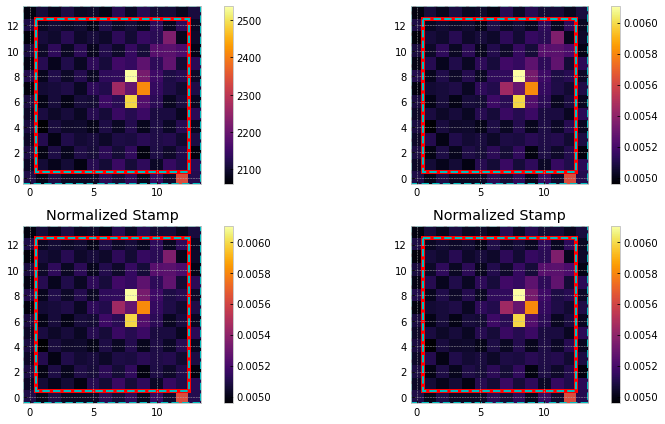

time: 936 ms


In [50]:
# Here we are looking at the PSC and the normalized, with the normalized on bottom, so it is a repeat of information.
helpers.show_stamps(
    pscs=[
        target_psc.reshape(observation.num_frames, stamp_size[0], stamp_size[1]), 
        normalized_psc.reshape(observation.num_frames, stamp_size[0], stamp_size[1])
    ], 
    stamp_size=stamp_size[0], 
    aperture_size=stamp_size[0] -2, 
    frame_idx=0) #, stretch='log')

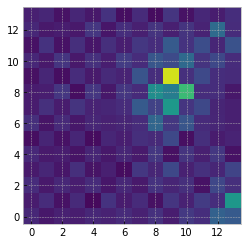

time: 6.06 s


In [13]:
# Outputs an animation that can be played. Also outputs a first frame that is annoying and in the way.
helpers.animate_stamp(target_psc.reshape(observation.num_frames, stamp_size[0], stamp_size[0]))

---
### 3) Find similar stars

We want to find stars that are similar to our target in terms of how they are placed on the detector (e.g. does the star fall mostly on a red pixel or a blue, etc.).

For this we ignore the flux and directly compare the morphology of each source with the target.

* Normalize each stamp of every PSC
* Find the sum-squared-difference for each PSC when compared to the target PSC.
* Result: A score (`v`) for each point source that indicates how closely it matches the shape of the target source.

In [14]:
# Get a score for each point source for how well it matches target. Lower scores are better matches
similar_stars = observation.find_similar_stars(picid, force_new=True, store=False)

# Sort by the similarity score so we can easily get best matches
similar_source_rank = pd.DataFrame({'v': similar_stars}, index=list(observation.stamps.keys())).sort_values(by='v')

41233it [00:59, 697.32it/s]


time: 59.4 s


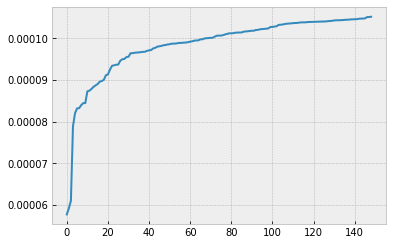

time: 185 ms


In [15]:
# Show similarity scores for top 100 matches
plt.plot(similar_source_rank.values[1:150])

### 4) Combine related stars

We want to take the reference stars that are most similar to our target and combine them into one "ideal"
template PSC. This step is done by linearly combining the normalized references to determine the proper coefficients.

In [16]:
# Guess at the number of references to start
num_refs = 100

# Damping parameter for fit
d = 0

time: 1.02 ms


In [17]:
# Build a collection of the top references. First item in list is target
ref_collection = np.array([observation.get_psc(idx) for idx in similar_source_rank.index[:num_refs]])

target_psc = ref_collection[0]

# Normalize each PSC in the reference stamp collection
normalized_collection = np.array([helpers.normalize(s) for s in ref_collection])

# Build the coeffs off the normalized PSC - this is the actual combination
coeffs = observation.get_ideal_full_coeffs(normalized_collection, damp=d, verbose=True)

Target other shape: (11760,)
Refs other shape: (11760, 99)
time: 124 ms


In [18]:
stamp_collection = normalized_collection

num_refs = stamp_collection.shape[0] - 1
num_frames = stamp_collection.shape[1]
num_pixels = stamp_collection.shape[2]

target_frames = stamp_collection[0].flatten()
refs_frames = stamp_collection[1:].reshape(-1, num_frames * num_pixels).T

print("Target other shape: {}".format(target_frames.shape))
print("Refs other shape: {}".format(refs_frames.shape))        

def func(c0):
    return target_frames - (refs_frames * c0).sum(1)

coeffs = optimize.leastsq(func, np.ones(num_refs))
# coeffs2 = lsqr(refs_frames, target_frames, d)

Target other shape: (11760,)
Refs other shape: (11760, 99)
time: 827 ms


In [19]:
d1 = (ref_collection[0] / (ref_collection[1:].T * coeffs[0]).T.sum(0)).sum(1)

time: 8.28 ms


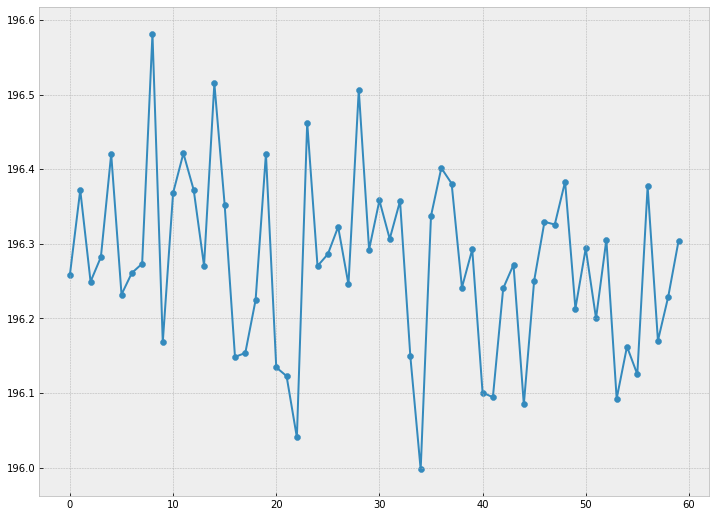

time: 357 ms


In [20]:
mean, med, std = sigma_clipped_stats(d1)
plt.figure(figsize=(12,9))
mean = 1
plt.scatter(range(observation.num_frames), d1 / mean)
plt.plot(range(observation.num_frames), d1 / mean)
# plt.ylim(.95, 1.05)

### 5) Create ideal template

We take the coefficients created from the normalized collection and apply them to the regular (non-normalized) collection.

In [21]:
# Build the template from the coeffs
ideal = observation.get_ideal_full_psc(ref_collection, coeffs[0])

time: 6.28 ms


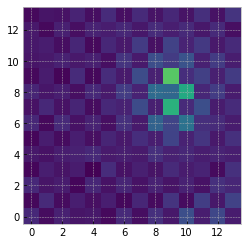

time: 3.89 s


In [22]:
# Show the generated ideal PSF
helpers.animate_stamp(ideal.reshape(observation.num_frames, stamp_size[0], stamp_size[0]))

### 6) Compare target to template

In [ ]:
r_stamp_mask =np.tile(rgb_stamp_masks[0].flatten(), observation.num_frames).reshape(observation.num_frames, stamp_size[0], stamp_size[1])
g1_stamp_mask =np.tile(rgb_stamp_masks[1].flatten(), observation.num_frames).reshape(observation.num_frames, stamp_size[0], stamp_size[1])
g2_stamp_mask =np.tile(rgb_stamp_masks[2].flatten(), observation.num_frames).reshape(observation.num_frames, stamp_size[0], stamp_size[1])
b_stamp_mask =np.tile(rgb_stamp_masks[3].flatten(), observation.num_frames).reshape(observation.num_frames, stamp_size[0], stamp_size[1])

In [ ]:

fig = plt.figure(figsize=(24,12))
ax1 = fig.add_subplot(111)

phase = np.arange(len(target_psc))

r_target = np.ma.array(target_psc.reshape(observation.num_frames, stamp_size[0], stamp_size[1]), mask=~r_stamp_mask)
g1_target = np.ma.array(target_psc.reshape(observation.num_frames, stamp_size[0], stamp_size[1]), mask=~g1_stamp_mask)
g2_target = np.ma.array(target_psc.reshape(observation.num_frames, stamp_size[0], stamp_size[1]), mask=~g2_stamp_mask)
b_target = np.ma.array(target_psc.reshape(observation.num_frames, stamp_size[0], stamp_size[1]), mask=~b_stamp_mask)

r_ideal = np.ma.array(ideal.reshape(observation.num_frames, stamp_size[0], stamp_size[1]), mask=~r_stamp_mask)
g1_ideal = np.ma.array(ideal.reshape(observation.num_frames, stamp_size[0], stamp_size[1]), mask=~g1_stamp_mask)
g2_ideal = np.ma.array(ideal.reshape(observation.num_frames, stamp_size[0], stamp_size[1]), mask=~g2_stamp_mask)
b_ideal = np.ma.array(ideal.reshape(observation.num_frames, stamp_size[0], stamp_size[1]), mask=~b_stamp_mask)

r_diff = (r_target.reshape(observation.num_frames, -1).sum(1) / r_ideal.reshape(observation.num_frames, -1).sum(1))
g1_diff = (g1_target.reshape(observation.num_frames, -1).sum(1) / g1_ideal.reshape(observation.num_frames, -1).sum(1))
g2_diff = (g2_target.reshape(observation.num_frames, -1).sum(1) / g2_ideal.reshape(observation.num_frames, -1).sum(1))
b_diff = (b_target.reshape(observation.num_frames, -1).sum(1) / b_ideal.reshape(observation.num_frames, -1).sum(1))

g3_diff = (
    (g1_target.reshape(observation.num_frames, -1).filled(0) + g2_target.reshape(observation.num_frames, -1).filled(0)).sum(1) / 
    (g1_ideal.reshape(observation.num_frames, -1).filled(0) + g2_ideal.reshape(observation.num_frames, -1).filled(0)).sum(1)
)

r_mean, r_med, r_std = sigma_clipped_stats(r_diff)
g1_mean, g1_med, g1_std = sigma_clipped_stats(g1_diff)
g2_mean, g2_med, g1_std = sigma_clipped_stats(g2_diff)
g3_mean, g3_med, g1_std = sigma_clipped_stats(g3_diff)
b_mean, b_med, b_std = sigma_clipped_stats(b_diff)

diff = (target_psc / ideal).sum(1) / target_psc.shape[-1]
diff2 = (target_psc.sum(1) / ideal.sum(1))

mean, median, std = sigma_clipped_stats(diff)
mean2, median2, std2 = sigma_clipped_stats(diff2)

# ax1.plot(phase, diff / mean, color='r', lw=4, label='n: {} D: {:.2f} $\mu$: {:.02f} $\sigma$: {:.02%}'.format(num_refs, d, mean, std / mean))       
# ax1.plot(phase, diff - mean + 1, color='b', lw=2, label='Pixel level')       
# ax1.plot(phase, diff2 - mean2 + 1, color='r', ls='--', lw=2, label='Stamp level')     

ax1.plot(phase, r_diff, color='r', lw=2, label='R channel')  
ax1.plot(phase, g1_diff, color='g', lw=2, label='G1 channel')  
ax1.plot(phase, g2_diff, color='c', lw=2, label='G2 channel')  
ax1.plot(phase, g3_diff, color='0', lw=2, label='G3 channel')  
ax1.plot(phase, b_diff, color='b', lw=2, label='B channel')  

ax1.hlines(1, phase[0], phase[-1], linestyles='dashed', alpha=0.5)
ax1.hlines(1.01, phase[0], phase[-1], linestyles='dashed', alpha=0.5, color='c')
ax1.hlines(.99, phase[0], phase[-1], linestyles='dashed', alpha=0.5, color='c')

ax1.legend()
# ax1.set_ylim(.95, 1.05)
ax1.set_xlim(phase[0], phase[-1])

---
#### Try different number of references

Here we run through a range of references and damping values. Note that this is running pipeline steps 3-6 for each set of values.

In [ ]:
fig = plt.figure(figsize=(24,12))
ax1 = fig.add_subplot(111)

def normalize(cube):
    return (cube.T / cube.sum(1)).T

for num_refs in np.arange(10, 200, 10):
    for d in np.arange(0, 5, 5):
        
        # Get all reference PSC
        stamp_collection = np.array([observation.get_psc(idx) for idx in similar_source_rank.index[:num_refs]])
        # Normalize each PSC
        normalized_collection = np.array([normalize(s) for s in stamp_collection])

        # Build the coeffs off the normalized PSC
        coeffs = observation.get_ideal_full_coeffs(normalized_collection, damp=d)

        # Build the template from the coeffs
        ideal = observation.get_ideal_full_psc(stamp_collection, coeffs[0])

        target_psc = stamp_collection[0]

#         diff = (target_psc / ideal).sum(1) / target_psc.shape[-1]
#         diff = diff / np.median(diff)
        diff = (target_psc.sum(1) / ideal.sum(1))

        mean, median, std = sigma_clipped_stats(diff)

        # Skip those that have a high std
#         if std / mean > .05:
#             continue

#         ax1.plot(phase, diff, alpha=0.25, label='n: {} D: {:.2f} $\mu$: {:.02f} $\sigma$: {:.02%}'.format(num_refs, d, mean, std / mean))   
        ax1.plot(diff, alpha=0.25, label='n: {} D: {:.2f} $\mu${:.02f} $\sigma$: {:.02%}'.format(num_refs, d, mean, std))   
#         ax1.scatter(phase, diff)   
        ax1.scatter(np.arange(len(diff)), diff)


# plt.plot(diff)
# plt.plot(psc.sum(1) / np.median(psc.sum(1)))

x_min = 0 
x_max = len(diff)
# x_min = phase.min()
# x_max = phase.max()
# ax1.hlines(1, x_min, x_max, linestyles='dashed', alpha=0.5)
# ax1.set_ylim(.8, 1.2)
ax1.set_xlim(x_min, x_max)

# ax1.set_xlabel('Phase')
ax1.set_ylabel('Relative flux')
ax1.legend()

# ax1.set_title("Relative photometry")

#### Run reduction

Here we have a fixed `num_refs` and damping value `d` and make a `run_piaa` method that runs reduction steps.

In [7]:
def normalize(cube):
    return (cube.T / cube.sum(1)).T

stamp_size = (14, 14)

def run_piaa(observation, picid, num_refs=50, damp=0):
    
    print("Getting similar sources")
    vary = observation.find_similar_stars(picid, force_new=True, display_progress=False, store=True)
    vary_series = pd.DataFrame({'v': list(vary.values())}, index=list(vary.keys())).sort_values(by='v')

    print("Building collection")
    ref_collection = np.array([observation.get_psc(idx) for idx in vary_series.index[:num_refs]])
    observation.num_frames = ref_collection[0].shape[0]
    #     print(ref_collection.shape)

    # Normalize each PSC
    print("Normalizing collection")
    normalized_collection = np.array([normalize(s) for s in ref_collection])

    # Build the coeffs off the normalized PSC
    print("Getting coefficients")
    coeffs = observation.get_ideal_full_coeffs(normalized_collection, damp=damp)
#     print(normalized_collection)

    # Build the template from the coeffs with non-normalized data
    print("Building ideal stamp")
    ideal = observation.get_ideal_full_psc(ref_collection, coeffs[0]).reshape(observation.num_frames, -1)

    target_psc = ref_collection[0].reshape(observation.num_frames, -1)
    
    rgb_stamp_masks = helpers.get_rgb_masks(target_psc[0].reshape(stamp_size[0], stamp_size[1]), force_new=True, separate_green=True)

    diff = list()
    for frame_idx in range(observation.num_frames):
        d0 = target_psc[frame_idx].reshape(stamp_size[0], stamp_size[1])
        i0 = ideal[frame_idx].reshape(stamp_size[0], stamp_size[1])

        star_pos = np.array(observation.stamps[picid]['original_position'])[frame_idx]
        slice0 = helpers.get_stamp_slice(star_pos[0], star_pos[1], stamp_size=stamp_size)
        
#         mean, median, std = sigma_clipped_stats(d0)
#         threshold = median + (5 * std)
#         try:
#             peak_tbl = find_peaks(d0, threshold)
#         except Exception as e:  # No peaks found
#             print("Error: ", e)
#             continue
    
        try:
#            aperture_position = (peak_tbl['x_peak'][0], peak_tbl['y_peak'][0])
            aperture_position = (star_pos[1] - slice0[0].start, star_pos[0] - slice0[1].start)
        except IndexError:
            print("No star position: ", frame_idx, slice0, star_pos)
            aperture_position = (5, 5)
        
        try:
            d1 = Cutout2D(d0, aperture_position, aperture_size, mode='strict')
            i1 = Cutout2D(i0, aperture_position, aperture_size, mode='strict')
        except (PartialOverlapError, NoOverlapError) as e:
            print("Bad overlap frame {}".format(frame_idx))
            print(aperture_position)
            continue
        
        d2 = d1.data
        i2 = i1.data
        
        # Here we are looking at the PSC and the normalized, with the normalized on bottom, so it is a repeat of information.
        if frame_idx == 1:
            helpers.show_stamps(
                pscs=[
                    target_psc.reshape(observation.num_frames, stamp_size[0], stamp_size[1]), 
                    ideal.reshape(observation.num_frames, stamp_size[0], stamp_size[1])
                ], 
                stamp_size=stamp_size[0], 
                aperture_size=aperture_size,
                aperture_position=aperture_position,
                frame_idx=frame_idx) #, stretch='log')
        
#         print(d2.shape, i2.shape)
        
        r_mask = ~rgb_stamp_masks[0][d1.slices_original]
        g1_mask = ~rgb_stamp_masks[1][d1.slices_original]
        g2_mask = ~rgb_stamp_masks[2][d1.slices_original]
        b_mask = ~rgb_stamp_masks[3][d1.slices_original]
        
        r_target = np.ma.array(d2, mask=r_mask)
        g1_target = np.ma.array(d2, mask=g1_mask)
        g2_target = np.ma.array(d2, mask=g2_mask)
        b_target = np.ma.array(d2, mask=b_mask)

        r_ideal = np.ma.array(i2, mask=r_mask)
        g1_ideal = np.ma.array(i2, mask=g1_mask)
        g2_ideal = np.ma.array(i2, mask=g2_mask)
        b_ideal = np.ma.array(i2, mask=b_mask)
                
#         print(r_target.shape)
#         print(r_ideal.shape)

        r_target_imag = -2.5 * np.log10(r_target.sum())
        g1_target_imag = -2.5 * np.log10(g1_target.sum())
        g2_target_imag = -2.5 * np.log10(g2_target.sum())
        b_target_imag = -2.5 * np.log10(b_target.sum())
        
        r_ideal_imag = -2.5 * np.log10(r_ideal.sum())
        g1_ideal_imag = -2.5 * np.log10(g1_ideal.sum())
        g2_ideal_imag = -2.5 * np.log10(g2_ideal.sum())
        b_ideal_imag = -2.5 * np.log10(b_ideal.sum())        

        r_diff_mag = r_target_imag - r_ideal_imag
        g1_diff_mag = g1_target_imag - g1_ideal_imag
        g2_diff_mag = g2_target_imag - g2_ideal_imag
        g3_diff_mag = ((g1_target_imag + g2_target_imag)/2) - ((g1_ideal_imag + g2_ideal_imag)/2)
        b_diff_mag = b_target_imag - b_ideal_imag
        
        r_diff = (r_target.sum() / r_ideal.sum())
        g1_diff = (g1_target.sum() / g1_ideal.sum())
        g2_diff = (g2_target.sum() / g2_ideal.sum())
        g3_diff = ((g1_target.filled(0) + g2_target.filled(0)).sum() / (g1_ideal.filled(0) + g2_ideal.filled(0)).sum())
        b_diff = (b_target.sum() / b_ideal.sum())
       
        total_diff = d2.sum() / i2.sum()
        total_diff_mag = (-2.5 * np.log10(d2.sum())) - (-2.5 * np.log10(i2.sum()))

        results = (
            r_diff,
            g3_diff,            
            b_diff,
            total_diff,
            r_diff_mag,
            g3_diff_mag,            
            b_diff_mag,
            total_diff_mag,            
            aperture_position[0],
            aperture_position[1],
        )
        diff.append(results)
        
        
    dset = diff_group.create_dataset(picid, data=np.array(diff), dtype='f4')
    dset.attrs['aperture_size'] = aperture_size
    
    return ideal

time: 20.4 ms


In [8]:
with open('/var/panoptes/tres3_transits.txt') as f:
    sequences = f.read().split('\n')
    sequences.pop() # Remove final newline

time: 1.95 ms


In [9]:
sequences.reverse()
sequences

['PAN001/Tres3/ee04d1/20180521T092247',
 'PAN001/Tres3/ee04d1/20180517T091558',
 'PAN001/Tres3/ee04d1/20170709T062841',
 'PAN001/Tres3/ee04d1/20170705T063125',
 'PAN001/Tres3/ee04d1/20170701T071947',
 'PAN001/Tres3/ee04d1/20170605T075119',
 'PAN001/Tres3/ee04d1/20170519T082200',
 'PAN001/Tres3/14d3bd/20180521T092247',
 'PAN001/Tres3/14d3bd/20180517T091558',
 'PAN001/Tres3/14d3bd/20170709T062841',
 'PAN001/Tres3/14d3bd/20170705T063125',
 'PAN001/Tres3/14d3bd/20170701T071947',
 'PAN001/Tres3/14d3bd/20170605T075119',
 'PAN001/Tres3/14d3bd/20170519T082200']

time: 5.04 ms


Starting PAN001/Tres3/14d3bd/20170519T082200
Getting similar sources


41234it [01:35, 430.61it/s]


Building collection
Normalizing collection
Getting coefficients
Building ideal stamp
Making RGB masks
Writing csv to /var/panoptes/images/lc/PAN001_Tres3_14d3bd_20170519T082200.csv
Making plot
Done with PAN001/Tres3/14d3bd/20170519T082200

Starting PAN001/Tres3/14d3bd/20170605T075119
Getting similar sources


41128it [01:03, 643.44it/s]


Building collection
Normalizing collection
Getting coefficients
Building ideal stamp
Making RGB masks
Writing csv to /var/panoptes/images/lc/PAN001_Tres3_14d3bd_20170605T075119.csv
Making plot
Done with PAN001/Tres3/14d3bd/20170605T075119

Starting PAN001/Tres3/14d3bd/20170701T071947


0it [00:00, ?it/s]

Getting similar sources


41090it [01:56, 352.33it/s]


Building collection
Normalizing collection
Getting coefficients
Building ideal stamp
Making RGB masks
Writing csv to /var/panoptes/images/lc/PAN001_Tres3_14d3bd_20170701T071947.csv
Making plot
Done with PAN001/Tres3/14d3bd/20170701T071947

Starting PAN001/Tres3/14d3bd/20170705T063125
Getting similar sources


10201it [01:10, 145.46it/s]

KeyboardInterrupt: 

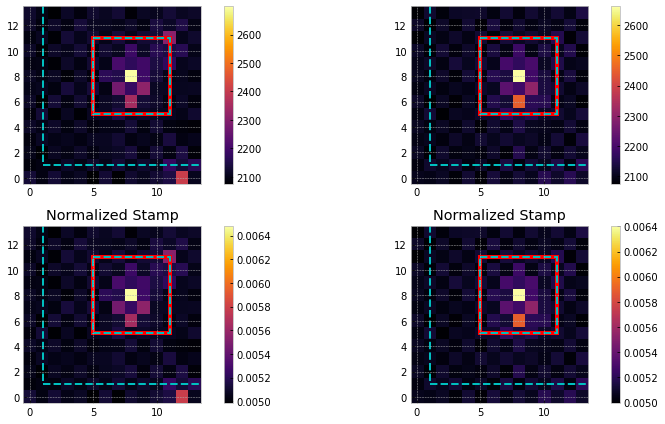

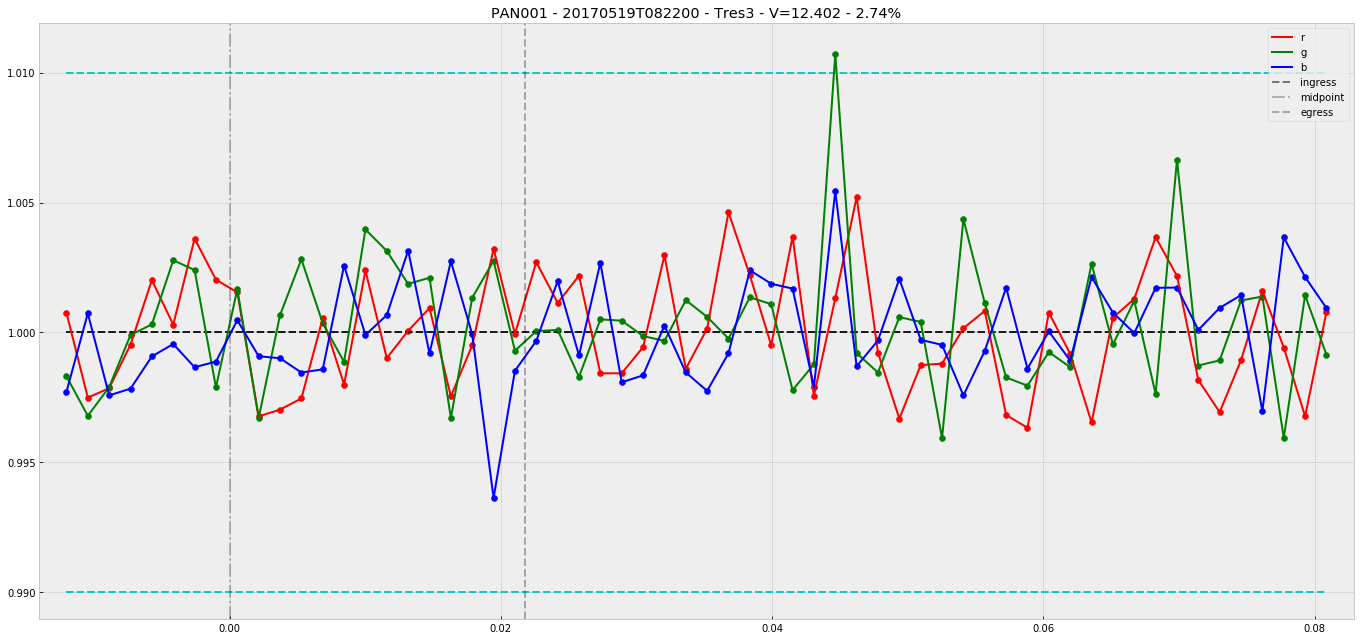

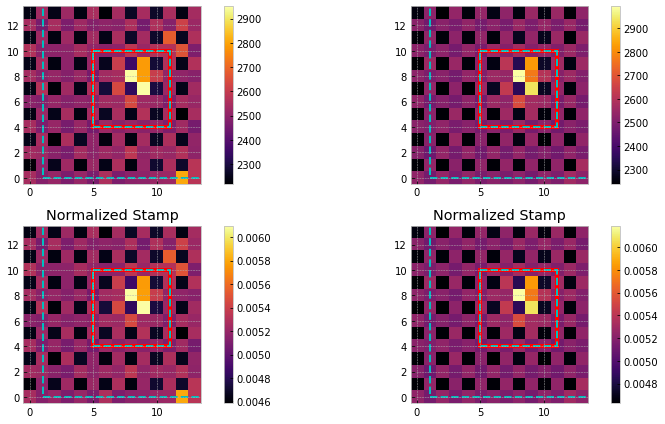

In [ ]:
num_refs = 75
d = 0

aperture_size = 6

picid = ticid

# for seq in sequences:
while sequences:
    seq = sequences.pop() # Don't do this
    
    if seq == '': continue
    print("Starting", seq)
    
    observation = Observation(seq)
    observation.get_stamps()
    
    if ticid not in observation.stamps:
        print(ticid, "not in observation, skipping")
        del observation
        continue

    try:
        diff_group = observation.hdf5_stamps['stamps/diffs']
    except KeyError:
        diff_group = observation.hdf5_stamps.create_group('stamps/diffs')
        
    try:
        del observation.hdf5_stamps['stamps/diffs'][picid]
    except KeyError:
        pass

    ideal = run_piaa(observation, picid, num_refs=num_refs)
    
    # Get information about transit
    image_times = Time(np.array(observation.stamps['image_times']), format='mjd')
    phases = [observation.planet.get_phase(t0) for t0 in image_times]
            
    diffs = np.array(observation.hdf5_stamps['stamps/diffs'][picid])

    lc = pd.DataFrame(diffs, index=image_times.to_datetime(), columns=[
        'red', 'green', 'blue', 'total', 
        'aperture_x', 'aperture_y',
        'red_mag', 'green_mag', 'blue_mag', 'total_mag',         
    ])            
    lc['phases'] = phases
    
    csv_file = '/var/panoptes/images/lc/{}.csv'.format(seq.replace('/', '_'))
    print("Writing csv to {}".format(csv_file))
    lc.to_csv(csv_file)
    
    for t0 in image_times:
        in_transit, transit_info = observation.planet.in_transit(t0, with_times=True)
        if in_transit:
            print("Making plot")
            do_plot(observation, image_times, transit_info)
            break
    
    print("Done with", seq)
    print()
    
    del observation

In [ ]:
# # Run for all stamps - WILL TAKE A LONG TIME
# observation.verbose = False
# for picid in tqdm_notebook(observation.stamps.keys()):        
#     if picid in diff_group:
#         continue

# #     psc = observation.get_psc(picid).reshape(observation.num_frames, -1)
# #     normalized_psc = normalize(psc)

#     run_piaa(picid)

# observation.verbose = True

In [ ]:
# A random high snr point source
# picid = high_snr[np.random.randint(len(high_snr))]
# picid

In [73]:
# The assigned target
picid = ticid
picid

'116264089'

time: 2.95 ms


In [ ]:
# Run for one stamp
try:
    del observation.hdf5_stamps['stamps/diffs'][picid]
except KeyError:
    pass

ideal = run_piaa(picid, num_refs=num_refs)

In [ ]:
t0 = target_psc.reshape(observation.num_frames, stamp_size[0], stamp_size[1]) / ideal.reshape(observation.num_frames, stamp_size[0], stamp_size[1])
helpers.animate_stamp(t0)

In [ ]:
frame_idx = 0

In [ ]:
aperture_position

In [ ]:
aperture_position = (observation.hdf5_stamps['stamps/diffs'][picid][frame_idx][4], observation.hdf5_stamps['stamps/diffs'][picid][frame_idx][5])
aperture_size = observation.hdf5_stamps['stamps/diffs'][picid].attrs['aperture_size']

# Show comparison of target and created ideal
helpers.show_stamps(pscs=[
            target_psc.reshape(observation.num_frames, stamp_size[0], stamp_size[1]),
            ideal.reshape(observation.num_frames, stamp_size[0], stamp_size[1])
        ], 
        stamp_size=stamp_size[0], 
        aperture_position=aperture_position,
        aperture_size=aperture_size, 
        frame_idx=frame_idx
           )#, stretch='log')

In [ ]:
# Show some residuals of the target and comparison
helpers.show_stamps(pscs=[
            target_psc.reshape(observation.num_frames, stamp_size[0], stamp_size[1]) / ideal.reshape(observation.num_frames, stamp_size[0], stamp_size[1]),
            target_psc.reshape(observation.num_frames, stamp_size[0], stamp_size[1]) - ideal.reshape(observation.num_frames, stamp_size[0], stamp_size[1])
        ], 
        stamp_size=stamp_size[0], 
        aperture_size=aperture_size, 
        aperture_position=aperture_position,
        frame_idx=0
        ) #, stretch='log')

---
**Scratchpad below**

Get some information about the transit

In [6]:
def do_plot(observation, image_times, transit_info):
    y = np.array(observation.hdf5_stamps['stamps/diffs'][picid])

    plt.figure(figsize=(19,9))

    ingress_phase = observation.planet.get_phase(transit_info.ingress)
    egress_phase = observation.planet.get_phase(transit_info.egress)

    obs_start_phase = observation.planet.get_phase(image_times[0])
    obs_stop_phase = observation.planet.get_phase(image_times[-1])

    # phase = np.arange(len(target_psc))
    phase = np.linspace(obs_start_phase, obs_stop_phase, observation.num_frames)

    for i, color in zip(range(y.shape[1]), ['r', 'g', 'b']):

        d0 = y[:, i]
        mean, med, std = sigma_clipped_stats(d0)

        d0 -= mean 
        d0 += 1

        # Offset lines from each other
    #     offset = i / 20
    #     d0 += offset
        offset = 0

        plt.plot(phase, d0, color=color, label=color)
    #     plt.scatter(range(observation.num_frames), d0, color=color)
        plt.scatter(phase, d0, color=color)

        plt.hlines(1 + offset, phase[0], phase[-1], linestyles='dashed', alpha=0.5)
        plt.hlines(1.01 + offset, phase[0], phase[-1], linestyles='dashed', alpha=0.5, color='c')
        plt.hlines(.99 + offset, phase[0], phase[-1], linestyles='dashed', alpha=0.5, color='c')    


    plt.axvline(ingress_phase, 0, color='k', ls='--', alpha=0.5, label='ingress')
    plt.axvline(0, 0, color='k', ls='-.', alpha=0.25, label='midpoint')
    plt.axvline(egress_phase, 0, color='k', ls='--', alpha=0.3, label='egress')

    # plt.ylim(0.9, 1.1)
    # plt.xlim(0, len(target_psc))
    plt.xlim(phase[0] - .002, phase[-1] + .002)

    plt.legend()
    plt.title("{} - {} - {} - V={} - {:.02%}".format(
        observation.unit_id,
        observation.seq_time,
        observation.field,
        observation.planet.star_mag, 
        observation.planet.transit_depth / 100
    ))
    plt.tight_layout()
    plt.savefig('/var/panoptes/images/lc/{}.png'.format(observation.sequence.replace('/','_')))

time: 8.4 ms
